In [2]:
# !python -m pip install "gymnasium[atari]"
# !python -m pip install "gymnasium[accept-rom-license, atari]"
# !pip install shimmy
# !pip install scikit-image

In [3]:
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import warnings
import ale_py
import shimmy
import joblib
import torch
import os

from gym import wrappers
from skimage.measure import block_reduce
from IPython.display import clear_output

| **Value** | **Meaning** |
|:---------:|:-----------:|
| 0 | NOOP |
| 1 | FIRE |
| 2 | RIGHT |
| 3 | LEFT |
| 4 | RIGHTFIRE |
| 5 | LEFTFIRE |

# Run Constants

In [4]:
render = False # render video output?
show = False
no_grad = False
corner_correct = False
plot_action_every = 0 # 64

timer_i = 2000 # number of iterations without reward before noise is intentionally greater than signal
dropout_i = 1000

record_actions = False # will be handled as true if plot_action_every > 0
record_probs = False
record_rewards = True

# Model Instantiation

In [5]:
def plot_probs(prob_list, step=1, dpi=200, subplot=True):
    probs_arr = torch.vstack(prob_list).detach().numpy()
    display(probs_arr.shape)
    
    if subplot:
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,12), dpi=dpi, sharex=True, sharey=True)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12), dpi=dpi)
        axs = [ax] * 6
    
    fig.suptitle('Single Episode Action Probabilities')
    colors = sns.color_palette('Spectral', 7)
    colors = colors[:3] + colors[4:]
    for i, (ax, color) in enumerate(zip(axs.flatten(), colors)):
        sns.lineplot(data=probs_arr[::step,i], color=color, label=action_dict[i], alpha=.7, dashes=False, ax=ax)
        ax.set_ylim([0,1])
    plt.xlabel('Iterations')
    plt.ylabel('Probability')
    plt.tight_layout()
    plt.show()
    return

def moving_average(a, window_size) :
    ret = np.cumsum(a, dtype=float)
    ret[window_size:] = ret[window_size:] - ret[:-window_size]
    return ret[window_size - 1:] / window_size

def plot_rewards(reward_list, window_size=10):
    plt.figure(figsize=(16,5))
    plt.title('Rewards Over Time')
    plt.ylabel('Total Reward')
    plt.xlabel('Episode Number')
    x = np.arange(0, len(reward_list), 1)
    assert len(x) == len(reward_list)
    plt.scatter(x, reward_list, color='black', label='Reward Per Episode')
    plt.plot(x[window_size-1:], moving_average(reward_list, window_size), color='red', label='Reward Moving Average')
    plt.legend()
    plt.show()
    return

In [6]:
def show_obs(obs):
    """ 
    Simple display of image observation 
    
    Args:
    `obs` : np.ndarray
    - Observation from the environment
    """
    plt.figure(figsize=(16,10))
    plt.imshow(obs)
    plt.show()
    return

def plot_action_counts(action_list):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    transform = lambda x : action_dict[int(x)]
    action_series = pd.Series(action_list, name='Count').dropna()
    data = action_series.value_counts().sort_index()
    data /= data.sum() # normalize to probabilities
    data.index = list(map(transform, data.index))
    data = data.to_frame().transpose()
    sns.barplot(data=data, palette='Spectral', ax=ax)
    plt.show()
    return

In [7]:
def add_noise(probs, i_since_r, timer_i, c=1, sigma=None, buffer=None):        
    # autograd no inplace ops
    if buffer is None:
        buffer = timer_i // 2
    n = len(probs)
    if sigma is None:
        sigma = 2 / n
    noise = torch.normal(0., sigma, (1, n), requires_grad=True) # means, stds shared, size n
    noise = noise - noise.mean()
    
    scale = c * i_since_r / (timer_i - buffer)

    probs = probs + noise * scale
    pmin = torch.min(probs)
    if pmin < 0:
        probs = probs - pmin
        probs = probs / torch.sum(probs)
        
    return probs

def balance_lr(probs, i_since_r, timer_i, beta=.5, buffer=None):
#     2 : 'RIGHT'
#     3 : 'LEFT'
#     4 : 'RIGHTFIRE'
#     5 : 'LEFTFIRE'
    if i_since_r < timer_i / 4:
        return probs
    elif i_since_r < timer_i / 2:
        alpha = .5
    elif i_since_r < timer_i * 3 / 4:
        alpha = .8
    else:
        alpha = .99

    zero_probs = torch.zeros_like(probs, requires_grad=True)
    zero_probs[0,2] = (probs[0,3] - probs[0,2])
    zero_probs[0,3] = (probs[0,2] - probs[0,3])
    
    zero_probs[0,4] = (probs[0,5] - probs[0,4])
    zero_probs[0,5] = (probs[0,4] - probs[0,5])
    zero_probs = zero_probs * alpha * beta / 2
    
    probs = probs + zero_probs
    with torch.no_grad():
        assert torch.sum(probs).round(decimals=3) == 1, torch.sum(probs)
    return probs

def standardize(x):
    eps = np.finfo(np.float64).eps.item()
    x = (x - x.mean()) / (x.std() + eps)
    return x

def balance_all(probs, i_since_r, timer_i, beta=2):
    probs = probs + 2 * i_since_r / timer_i
    probs = softmax = nn.Softmax(dim=-1)(probs)
    return probs
    
def modify_reward(action, reward, info, prev_lives, i_since_r, timer_i=1000, reward_dict=None):
    if reward_dict is None:
        reward_dict = {
            'life_penalty' : 15,
            'nofire_penalty' : .1,
            'comeback_reward' : 10,
        }
    if info['lives'] < prev_lives:
        reward += reward_dict['life_penalty']
    if reward <= 0 and action in [1,4,5]:
        reward += reward_dict['nofire_penalty']
    if reward > 0 and i_since_r > timer_i / 2:
        reward += reward_dict['comeback_reward']
    return reward

In [8]:
def process_probs(probs, i_since_r, timer_i=1000, corner_correct=True):
    truncated = i_since_r > timer_i
        
    if corner_correct: # heavily biases agent from getting 'stuck' in corner
        probs = add_noise(probs, i_since_r, timer_i)
        probs = balance_lr(probs, i_since_r, timer_i)
    else:
        probs = balance_all(probs, i_since_r, timer_i)

    if torch.round(torch.sum(probs), decimals=4) != 1:
        raise ValueError('Probs do not sum to 1')
        
    return probs, truncated

In [9]:
# OBS_SHAPE = (210, 160)
action_dict = {
    0 : 'NOOP',
    1 : 'FIRE',
    2 : 'RIGHT',
    3 : 'LEFT',
    4 : 'RIGHTFIRE',
    5 : 'LEFTFIRE'
}
ACTIONS = [0,1,2,3,4,5] # modify to limit available actions

In [10]:
class LinearReinforcement(nn.Module):
    def __init__(
        self, 
        hidden_dim, 
        output_dim, 
        gamma=.99, 
        lr=.1,
        xmin=26, 
        xmax=196, 
        ymin=10, 
        ymax=144,
        downsample = 'horizontal',
        writer=None,
        drop_p=0,
        **layer_kwargs,
    ):
        super(LinearReinforcement, self).__init__()
        self.gamma = gamma
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.downsample = downsample
        self.writer = writer
        self.iterations = 0
        self.drop_p = drop_p
        
        # preprocess args
        input_shape = (xmax - xmin, ymax - ymin)
        input_dim = np.prod(input_shape)
        if downsample == 'horizontal':
            input_dim //= 2
        elif downsample == 'max_pool':
            input_dim //= 4
        self.input_dim = input_dim

        self.log_probss = list()
        self.rewards = list()
        self.episode_losses = list()
    
        self.define_layers(input_dim, hidden_dim, output_dim, **layer_kwargs)
        
        self.optimizer = torch.optim.RMSprop(self.parameters(), lr=lr)
        return
    
    def define_layers(self, input_dim, hidden_dim, output_dim):
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU(inplace=True)
#         self.dropout = nn.Dropout(p=drop_p)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)
        return
    
    def forward(self, x):
        assert len(x.shape) == 2
        x = self.layer1(x)
        x = self.activation(x)
#         x = self.dropout(x)
        if hasattr(self, 'drop_p'):
            x = nn.functional.dropout(x, p=self.drop_p)
        x = self.layer2(x)
        probs = self.softmax(x)
        return probs

    def discount_rewards(self):
        running_add = 0
        discounted_rewards = list()
        for reward in self.rewards:
            running_add = running_add * self.gamma + reward
            discounted_rewards.append(running_add)
            if self.writer:
                self.writer.add_scalar('Reward', running_add, global_step=self.iterations)
                self.iterations += 1
            
        discounted_rewards = torch.tensor(list(reversed(discounted_rewards)))
        return discounted_rewards

    def reward_loss(self):
        assert len(self.rewards)

        discounted_rewards = self.discount_rewards()
        discounted_rewards = standardize(discounted_rewards)
        log_probs = -torch.cat(self.log_probss)
        
        loss = torch.sum(torch.mul(log_probs, discounted_rewards))
        return loss
    
    def episode_backward(self):
        assert len(self.log_probss)
        episode_loss = self.reward_loss()
        self.episode_losses.append(episode_loss.unsqueeze(0))
        
        self.log_probss.clear()
        self.rewards.clear()
        return self
    
    def batch_backward(self):
        assert len(self.episode_losses)
        self.optimizer.zero_grad() # make sure this shouldn't go in reward_loss
        loss = torch.sum(torch.cat(self.episode_losses))
        loss.backward()
        self.optimizer.step()
        self.episode_losses.clear()
        return self
    
    def clear(self):
        self.log_probss.clear()
        self.rewards.clear()
        return
    
    def save(self, save_path):
        if save_path is None:
            save_path = f'{self.linear_layer.out_features}n_model.pt'
        torch.save(self.state_dict(), save_path)
        return
        
    def preprocess(self, x):
        assert x.shape == (210, 160)
        x = x[self.xmin:self.xmax,self.ymin:self.ymax]
        if self.downsample == 'horizontal':
            x = x[::2,:]
        x[x == 144] = 0 # erase background (background type 1)
        x[x == 109] = 0 # erase background (background type 2)
        x[x != 0] = 1 # everything else to 1
        if self.downsample == 'max_pool':
            # ideally downsampling would be done before changing values in place, but this way the background is ignored easily
            x = block_reduce(x, (2, 2), np.amax)
        x = torch.from_numpy(x.ravel()).float().unsqueeze(dim=0)
        return x

In [11]:
class CNNReinforcement(LinearReinforcement):   
    def define_layers(self, input_dim, hidden_dim, output_dim, drop_p=0, pool_kernel=2):
        self.cnn1 = nn.CNN2d(1, hidden_dim)
        self.norm1 = nn.BatchNorm2d(hidden_dim)
        self.activation = nn.ReLU(inplace=True)
        
        self.cnn2 = nn.CNN2d(hidden_dim, hidden_dim)
        self.norm2 = nn.BatchNorm2d(hidden_dim)
        self.max_pool = nn.MaxPool2d(2)
        
#         self.dropout = nn.Dropout(p=drop_p)
        self.linear1 = nn.Linear(hidden_dim // 2, output_dim)
        self.softmax = nn.Softmax(dim=-1)
        return
    
    def forward(self, x):
        assert len(x.shape) == 2
        x = self.cnn1(x)
        x = self.activation(x)
        x = self.norm1(x)
        x = self.cnn2(x)
        x = self.activation(x)
        x = self.norm2(x)
        
        
        if hasattr(self, 'drop_p'):
            x = nn.functional.dropout(x, p=self.drop_p)
        x = self.linear1(x)
        x = self.softmax(x)
        return x
    
    def preprocess(self, x):
        assert x.shape == (210, 160)
        x = x[self.xmin:self.xmax,self.ymin:self.ymax]
        if self.downsample == 'horizontal':
            x = x[::2,:]
        x[x == 144] = 0 # erase background (background type 1)
        x[x == 109] = 0 # erase background (background type 2)
        x[x != 0] = 1 # everything else to 1
        if self.downsample == 'max_pool':
            raise ValueError('Apply max pool in network, not as preprocessing')
#             # ideally downsampling would be done before changing values in place, but this way the background is ignored easily
#             x = block_reduce(x, (2, 2), np.amax)
        x = torch.from_numpy(x).float().unsqueeze(dim=0)
        return x

In [12]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import gc

save_path = 'model.pt'
always_collect = True
clear = True
resume = True # resume training from previous checkpoint

model = LinearReinforcement(
    128, 
    6, 
    writer=SummaryWriter()
).float()

# this is awful I know
if resume:
    try:
        model = model.load_state_dict(torch.load(save_path))
    except (FileNotFoundError, RuntimeError):
        raise FileNotFoundError('Provide a valid file corresponding to a saved model')
elif Path(save_path).is_file():
    raise ValueError('File already in use, choose unused model save path')

In [13]:
def plot_batch_bar(rewards, batch_size, clear=False):
    if clear:
        clear_output()
    assert not len(rewards) % batch_size, len(rewards)
    n_splits = len(rewards) // batch_size
    data = pd.DataFrame(
        {
            f'Batch {i}' : rewards[i:i+batch_size]
            for i
            in range(n_splits)
        }
    )
    plt.figure(figsize=(16,10))
    sns.barplot(data=data, palette='mako')
    plt.show()
    return

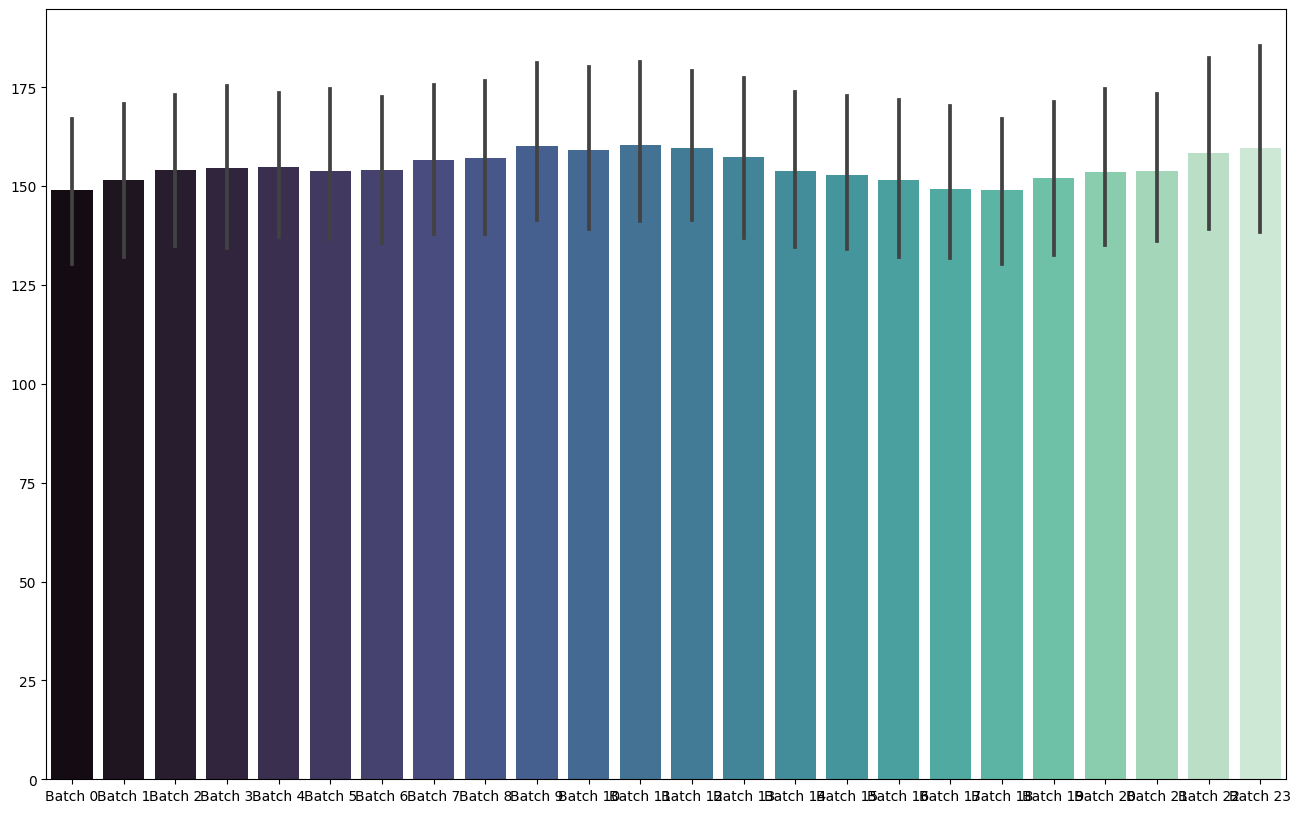

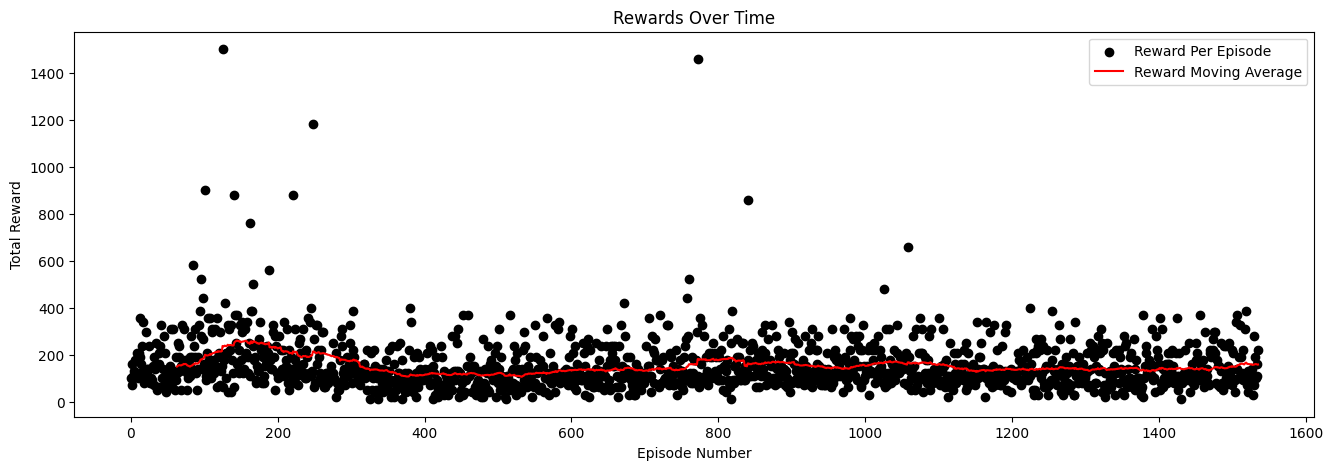

In [ ]:
n_episodes = 2560 * 4
batch_size = 64
print_every = 1200
apply_stop = False

prev_x = None # used in computing the difference frame
reward_sum = 0
adj_reward_sum = 0
last_i = 0
env = gym.make(
    'ALE/DemonAttack-v5', # alternate games can be chosen here 
    obs_type='grayscale', # saves RGB preprocessing reduction
    render_mode='human' if render else None, # rendering shows popup but limits training speed
)

if record_actions:
    action_list = list()
if record_rewards:
    reward_list = list()
if record_probs:
    prob_list = list()

episode_number = 0
prev_lives = 0
i = 0
e_ = 0

obs, info = env.reset()
while episode_number <= n_episodes:
    curr_x = model.preprocess(obs)
    x = curr_x - prev_x if prev_x is not None else torch.zeros((1, model.input_dim), requires_grad=True).float() # only monitor change between frames
    prev_x = curr_x
    assert x.dim() == 2, x.dim()
    model_probs = model(x)
    
    i_since_r = i - last_i
    probs, ptruncated = process_probs(model_probs, i_since_r, timer_i=timer_i, corner_correct=corner_correct)
    probs = (probs + torch.tensor([1/len(probs)] * len(probs)) * e_)
    probs = probs / probs.sum()
    
    if record_probs:
        prob_list.append(probs)

    m = torch.distributions.Categorical(probs)
    action = m.sample() 

    log_probs = m.log_prob(action)
    model.log_probss.append(log_probs)
    action = action.item()

    if record_actions or plot_action_every:
        action_list.append(action)

    obs, reward, terminated, truncated, info = env.step(action) # step returns all other relevant information 
    if apply_stop:
        truncated = truncated or ptruncated
    elif i_since_r > 100000:
        warnings.warn('')
        truncated = True
    elif i_since_r > dropout_i:
        drop_p = (i_since_r - dropout_i) / dropout_i
        model.drop_p = drop_p if drop_p < .8 else .8
    
    if reward > 0: # reset the iterations since last reward if reward is accrued
        last_i = i
        e_ = 0
        model.drop_p = 0.01
    else:
        e_ += .000001
        
    reward_sum += reward # total round reward incremented
    
    adj_reward = modify_reward(action, reward, info, prev_lives, i_since_r, timer_i=timer_i) # adjusted reward may better lead agent toward short term optimums
    prev_lives = info['lives']
    adj_reward_sum += adj_reward
    model.rewards.append(adj_reward)
    ######################################################
    
        
    if terminated: # an episode finished
        if record_rewards:
            reward_list.append(reward_sum)
        print(f'\nEpisode {episode_number} of {n_episodes}, Iterations : {i}            \n\n', end='\r')
        
        episode_number += 1

        # Finish The Episode.save
        model.episode_backward()
                
        # Finish the Batch
        if not no_grad and not episode_number % batch_size:           
            if record_rewards:
                plot_batch_bar(reward_list, batch_size, clear=clear)
                plot_rewards(reward_list, window_size=batch_size)
            model.batch_backward()
            if not model.writer:
                model.save(save_path)
            if always_collect:
                gc.collect()
            
        if plot_action_every and not episode_number % plot_action_every:
            plot_action_counts(action_list)
            action_list.clear()

    elif truncated: # an episode terminated unexpectedly, shouldn't maintain results
        model.episode_losses.clear()
        model.log_probss.clear()
        model.rewards.clear()       
    elif print_every and not i % print_every:
        print(i)
    else:
        print(i, end='                          \r')
        
    if terminated or truncated:
        reward_sum = 0
        adj_reward_sum = 0
        
        obs, info = env.reset()
        prev_x = None
        i = 0
        prev_lives = 3 # for new episode adjustment
        if record_probs:
            plot_probs(prob_list, dpi=80)
            prob_list.clear()
    i += 1

env.close()

In [ ]:
!tensorboard --logdir=runs

if record_probs:
    plot_probs(prob_list)
if record_rewards:
    plot_rewards(reward_list, window_size=200)

[TensorBoard](localhost:6006/)